# Tutorial on word2vec

In [71]:
import io
import re
import string
import tqdm
import numpy as np
import multiprocessing
from gensim.models import Word2Vec
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
module_path = '/Users/clairehe/Documents/GitHub/STATGR2022/Example/lib'
if module_path not in sys.path:
    sys.path.append(module_path)
from wordcloud_maker import *
from gensim.models.phrases import Phrases, Phraser

In [17]:
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

In [8]:
#help(Word2Vec)

## Preprocessing the data

### Cleaning data

In [15]:
nlp = spacy.load("en_core_web_sm") # disabling Named Entity Recognition for speed


In [19]:
folder = 'https://raw.githubusercontent.com/megagonlabs/HappyDB/master/happydb/data/'
cleaned_hm = pd.read_csv(folder+'cleaned_hm.csv', sep = ",",on_bad_lines='skip')

In [32]:
np.sum(cleaned_hm['original_hm'].isnull()) # no missing data 

0

In [51]:
t = time.time()
brief_clean = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in cleaned_hm['original_hm']) # remove non alphabetical 
txt = [cleaning(doc) for doc in nlp.pipe(brief_clean, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to clean up everything: 1.36 mins


  0%|          | 0/100535 [00:00<?, ?it/s]

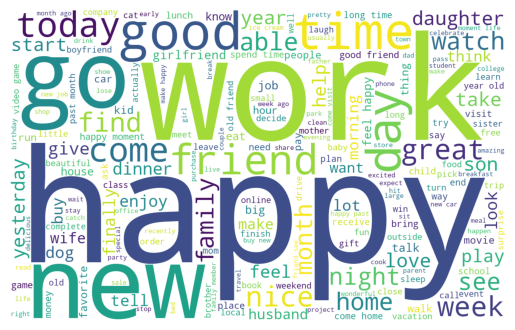

In [74]:
make_word_cloud_list(txt)

In [93]:
import itertools
res = list(itertools.filterfalse(lambda item: not item , txt)) # remove None produced

### Find bigrams/trigrams 

In [96]:
sent = []
for piece in res:
    sent.append(piece.split())

In [106]:
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
trigram = Phrases(sentences)

In [112]:
for piece in sent[:5]:
    tokens_ = trigram[piece]
    print(tokens_)

['go', 'successful', 'date', 'feel', 'sympathy', 'connection']
['happy', 'son', 'get', 'mark', 'examination']
['go', 'gym', 'morning', 'yoga']
['talk', 'friend', 'flaky', 'lately', 'understand', 'good', 'evening', 'hang']
['go', 'grandchild', 'butterfly', 'display', 'crohn', 'conservatory']


## Training the data

In [7]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model = Word2Vec(min_count=20, # load a pretrained word2vec model
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1) 

In [113]:
t = time.time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [114]:
t = time.time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.28 mins


In [119]:
w2v_model.wv.most_similar(positive=["happy"])

[('surprising', 0.4149363338947296),
 ('moment', 0.4055500626564026),
 ('goodness', 0.3856075406074524),
 ('excited', 0.3779650926589966),
 ('fulfil', 0.36929523944854736),
 ('proud', 0.36301389336586),
 ('cherish', 0.3451489210128784),
 ('joy_laughter', 0.344062864780426),
 ('make', 0.334505170583725),
 ('feel', 0.32927218079566956)]

In [122]:
cleaned_hm

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection
...,...,...,...,...,...,...,...,...,...
100530,128762,112,24h,My husband announced he is getting a decent bo...,My husband announced he is getting a decent bo...,True,1,NaN,affection
100531,128763,714,24h,Had a can of Pepsi to drink.,Had a can of Pepsi to drink.,True,1,NaN,enjoy_the_moment
100532,128764,3934,24h,Cuddling with my girlfriend last night.,Cuddling with my girlfriend last night.,True,1,affection,affection
100533,128765,1629,24h,I had a great meeting yesterday at work with m...,I had a great meeting yesterday at work with m...,True,1,NaN,bonding


In [129]:
w2v_model.wv.most_similar(positive=['affection'], topn = 10)

[('purr', 0.6710321307182312),
 ('loving', 0.6505423188209534),
 ('lick', 0.6432094573974609),
 ('affectionate', 0.6068466305732727),
 ('playful', 0.582502007484436),
 ('cuddle', 0.5779139995574951),
 ('snuggle', 0.564267635345459),
 ('curl', 0.5518242716789246),
 ('cheek', 0.5357925295829773),
 ('chest', 0.5253459215164185)]

In [130]:
w2v_model.wv.most_similar(positive=['cat'], topn = 10)

[('kitten', 0.7451218366622925),
 ('dog', 0.7438264489173889),
 ('purr', 0.7111768126487732),
 ('pet', 0.655433714389801),
 ('puppy', 0.6553908586502075),
 ('curl', 0.6478815078735352),
 ('pup', 0.643466591835022),
 ('stray', 0.6304631233215332),
 ('kitty', 0.6252504587173462),
 ('litter', 0.6089467406272888)]

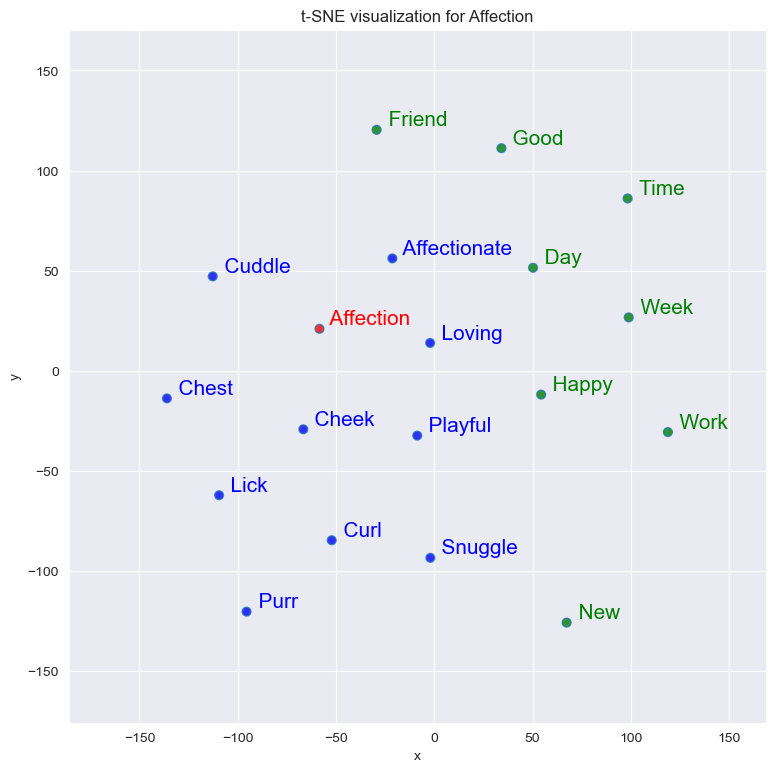

In [132]:
tsnescatterplot(w2v_model, 'affection', ['good', 'happy', 'work', 'time', 'day', 'new', 'week', 'friend'], 12)

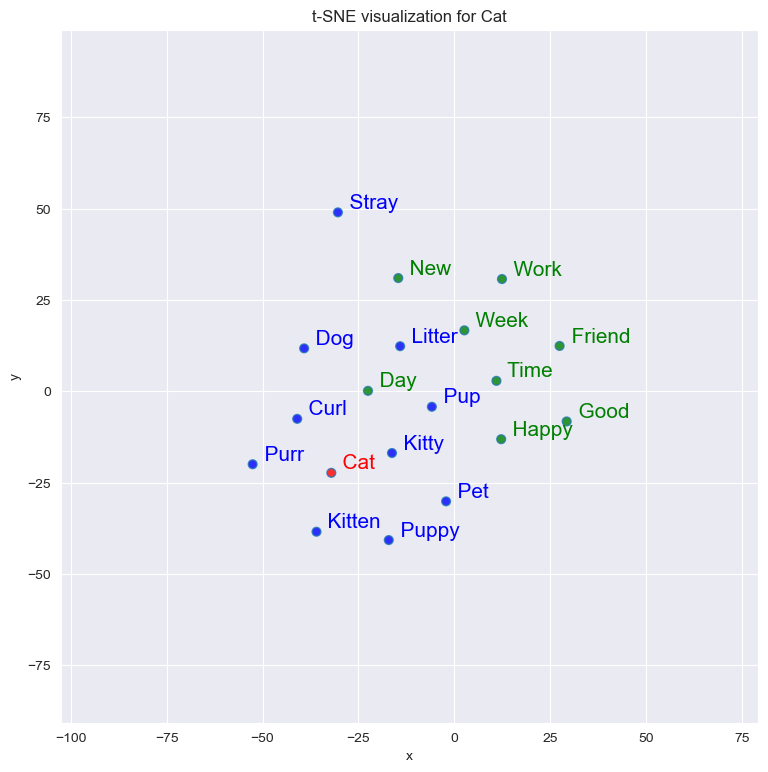

In [133]:
tsnescatterplot(w2v_model, 'cat', ['good', 'happy', 'work', 'time', 'day', 'new', 'week', 'friend'], 12)